Import

In [22]:
import sys

sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import cv2
import json
from pprint import pprint
import random

Helper Functions

In [23]:
def extract_id(file_name: str) -> str | None:
    """
    Give a file name such as 'A_P000001_PAS_CPG.tif',
    Extract the file ID: 'A_P000001' using regular expression
    """
    match = re.match(r"([A-Z]_P\d+)_", file_name, re.IGNORECASE)

    if match:
        return match.group(1)
    else:
        return None


def cell_mask_to_rgb(cell_mask: np.ndarray) -> np.ndarray:
    """For visualization purposes
    Convert 2D cell mask to an RGB image
    2D cell mask:
    1 - Lympchoyte centroids
    2 - Monocytes centroids
    RGB image:
    Green - Lympchoyte centroids
    Blue - Monocytes centroids
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    cell_mask = cv2.dilate(cell_mask, kernel, iterations=1)
    rgb_mask = np.zeros(
        (cell_mask.shape[0], cell_mask.shape[1], 3), dtype=np.uint8
    )
    rgb_mask[cell_mask == 1] = (0, 255, 0)
    rgb_mask[cell_mask == 2] = (0, 0, 255)
    return rgb_mask

Visualize 50 random patches

In [ ]:
# Specify data folders

# Folder containing image patches
patch_image_dir = "/home/u1910100/Documents/Monkey/patches_512/images"
# Folder containing cell masks
cell_mask_dir = (
    "/home/u1910100/Documents/Monkey/patches_512/annotations/masks"
)
# Folder containing json files
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_512/annotations/json"
)


# Visualize 50 random patches
file_names = os.listdir(patch_image_dir)
files_sample = random.sample(file_names, 50)

for name in files_sample:
    name_without_ext = os.path.splitext(name)[0]

    # Get path to files
    patch_image_path = os.path.join(
        patch_image_dir, f"{name_without_ext}.npy"
    )
    cell_mask_path = os.path.join(
        cell_mask_dir, f"{name_without_ext}.npy"
    )
    json_path = os.path.join(json_dir, f"{name_without_ext}.json")

    # load RGB patch and cell mask
    image_patch = np.load(patch_image_path)
    cell_mask = np.load(cell_mask_path)
    # Convert cell mask to RGB image for visualization
    rgb_cell_mask = cell_mask_to_rgb(cell_mask)

    # load json file
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    # Output
    pprint(name)
    # pprint(annotations)
    fig, axes = plt.subplots(1, 3, figsize=(17, 17))
    axes[0].imshow(image_patch)
    axes[0].title.set_text("RGB Patch")
    axes[1].imshow(rgb_cell_mask)
    axes[1].title.set_text("Cell Mask")
    axes[2].imshow(image_patch, alpha=0.5)
    axes[2].imshow(rgb_cell_mask, alpha=0.5)
    axes[2].title.set_text("Cell Mask overlay on RGB Patch")
    plt.show()

Count cells

In [19]:
# Folder containing json files
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_512/annotations/json"
)
file_names = os.listdir(json_dir)

lymphocyte_count = 0
monocytes_count = 0

for name in file_names:
    json_path = os.path.join(json_dir, name)
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    lymph_coords = annotations["lymphocytes"]
    mono_coords = annotations["monocytes"]

    lymphocyte_count += len(lymph_coords)
    monocytes_count += len(mono_coords)


print(f"lympho count = {lymphocyte_count}")
print(f"mono count = {monocytes_count}")

lympho count = 40592
mono count = 22377


In [20]:
# Create patch stats
json_dir = (
    "/home/u1910100/Documents/Monkey/patches_512/annotations/json"
)

stats_save_path = (
    "/home/u1910100/Documents/Monkey/patches_512/patch_stats.json"
)

patch_stats = {}

p = 0
n = 0

file_names = os.listdir(json_dir)
for name in file_names:
    name_without_ext = os.path.splitext(name)[0]
    json_path = os.path.join(json_dir, name)
    annotations = {}
    with open(json_path, "r") as file:
        annotations = json.load(file)

    lymph_coords = annotations["lymphocytes"]
    mono_coords = annotations["monocytes"]

    patch_stats[name_without_ext] = {
        "lymph_count": len(lymph_coords),
        "mono_count": len(mono_coords),
    }

    if len(lymph_coords) > 0 or len(mono_coords) > 0:
        p += 1
    else:
        n += 1

print(p)
print(n)
with open(stats_save_path, "w") as file:
    json.dump(patch_stats, file)

2296
139


Visualize Detection Dataloader

In [ ]:
%reset -f
import sys

sys.path.append("../")
from monkey.data.dataset import get_detection_dataloaders
from monkey.data.data_utils import imagenet_denormalise
from monkey.config import TrainingIOConfig
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

use_nuclick_masks = False
batch_size = 8
module = "detection"

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
    save_dir="./",
)
if use_nuclick_masks:
    IOconfig.set_mask_dir(
        "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
    )


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=1,
    dataset_name="detection",
    batch_size=batch_size,
    do_augmentation=True,
    module=module,
    target_cell_type="mono",
)

In [ ]:
def binary_to_rgb(binary_mask):
    rgb = np.zeros(
        (binary_mask.shape[0], binary_mask.shape[1], 3),
        dtype=np.uint8,
    )
    rgb[:, :, 0] = binary_mask * 255
    rgb[:, :, 1] = binary_mask * 255
    rgb[:, :, 2] = binary_mask * 255
    return rgb

In [ ]:
data = next(iter(train_loader))
print(module)
print(data["id"])
fig, axes = plt.subplots(batch_size, 3, figsize=(12, 18))

for i in range(batch_size):
    image = data["image"][i].numpy()
    image = np.moveaxis(image, 0, 2)
    image = imagenet_denormalise(image)
    axes[i][0].imshow(image)

    if module == "detection":
        mask = data["mask"][i][0].numpy()
        axes[i][1].imshow(mask, cmap="gray")
        axes[i][2].imshow(image, alpha=0.5)
        axes[i][2].imshow(mask, alpha=0.5)

    if module == "multiclass_detection":

        mask = data["mask"][i].numpy()
        axes[i][1].imshow(mask[0], cmap="jet")
        axes[i][1].set_title("lymphocytes")
        axes[i][2].imshow(mask[1], cmap="jet")
        axes[i][2].set_title("monocytes")

        for ax in axes.ravel():
            ax.axis("off")

plt.show()

Visualize Classification DataLoader

In [ ]:
%reset -f
import sys

sys.path.append("../")
from monkey.data.dataset import get_classification_dataloaders
from monkey.data.data_utils import imagenet_denormalise
from monkey.config import TrainingIOConfig
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir="./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
batch_size = 2
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=1,
    batch_size=batch_size,
    do_augmentation=True,
)

In [ ]:
data = next(iter(val_loader))
fig, axes = plt.subplots(batch_size, 2, figsize=(8, 8))

for i in range(batch_size):
    print(data["id"][i])
    print(data["label"][i])
    # print(data["label"].shape)
    # break
    image = data["image"][i].numpy()
    mask = data["mask"][i][0].numpy()

    image = np.moveaxis(image, 0, 2)
    image = imagenet_denormalise(image)

    axes[i][0].imshow(image)
    axes[i][1].imshow(mask, cmap="gray")
plt.show()

Visualize Multitask Dataset

In [25]:
%reset -f
import sys

sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import os
import random
from monkey.data.dataset import get_detection_dataloaders
from monkey.config import TrainingIOConfig
from monkey.data.data_utils import imagenet_denormalise


IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_512",
    save_dir="./",
)

# IOconfig.set_mask_dir(
#     "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
# )

batch_size = 8
train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=1,
    dataset_name="multitask",
    batch_size=batch_size,
    do_augmentation=True,
    use_nuclick_masks=False,
    disk_radius=9,
)

# def binary_to_color(mask):
#     rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
#     rgb[:, :, 0] = np.where(mask == 1, 255, 0)
#     rgb[:, :, 1] = np.where(mask == 2, 255, 0)
#     return rgb

negative pixels: 115564800
lymph pixels: 7490048
mono pixels: 4019456
train patches: 1939
test patches: 496


['C_P000034_33984_14160_34496_14672', 'B_P000007_41536_10384_42048_10896', 'C_P000039_31152_139712_31664_140224', 'A_P000024_14160_118944_14672_119456', 'D_P000009_13216_59944_13728_60456', 'B_P000007_41536_10384_42048_10896', 'A_P000033_31152_99592_31664_100104', 'A_P000014_63248_86848_63760_87360']


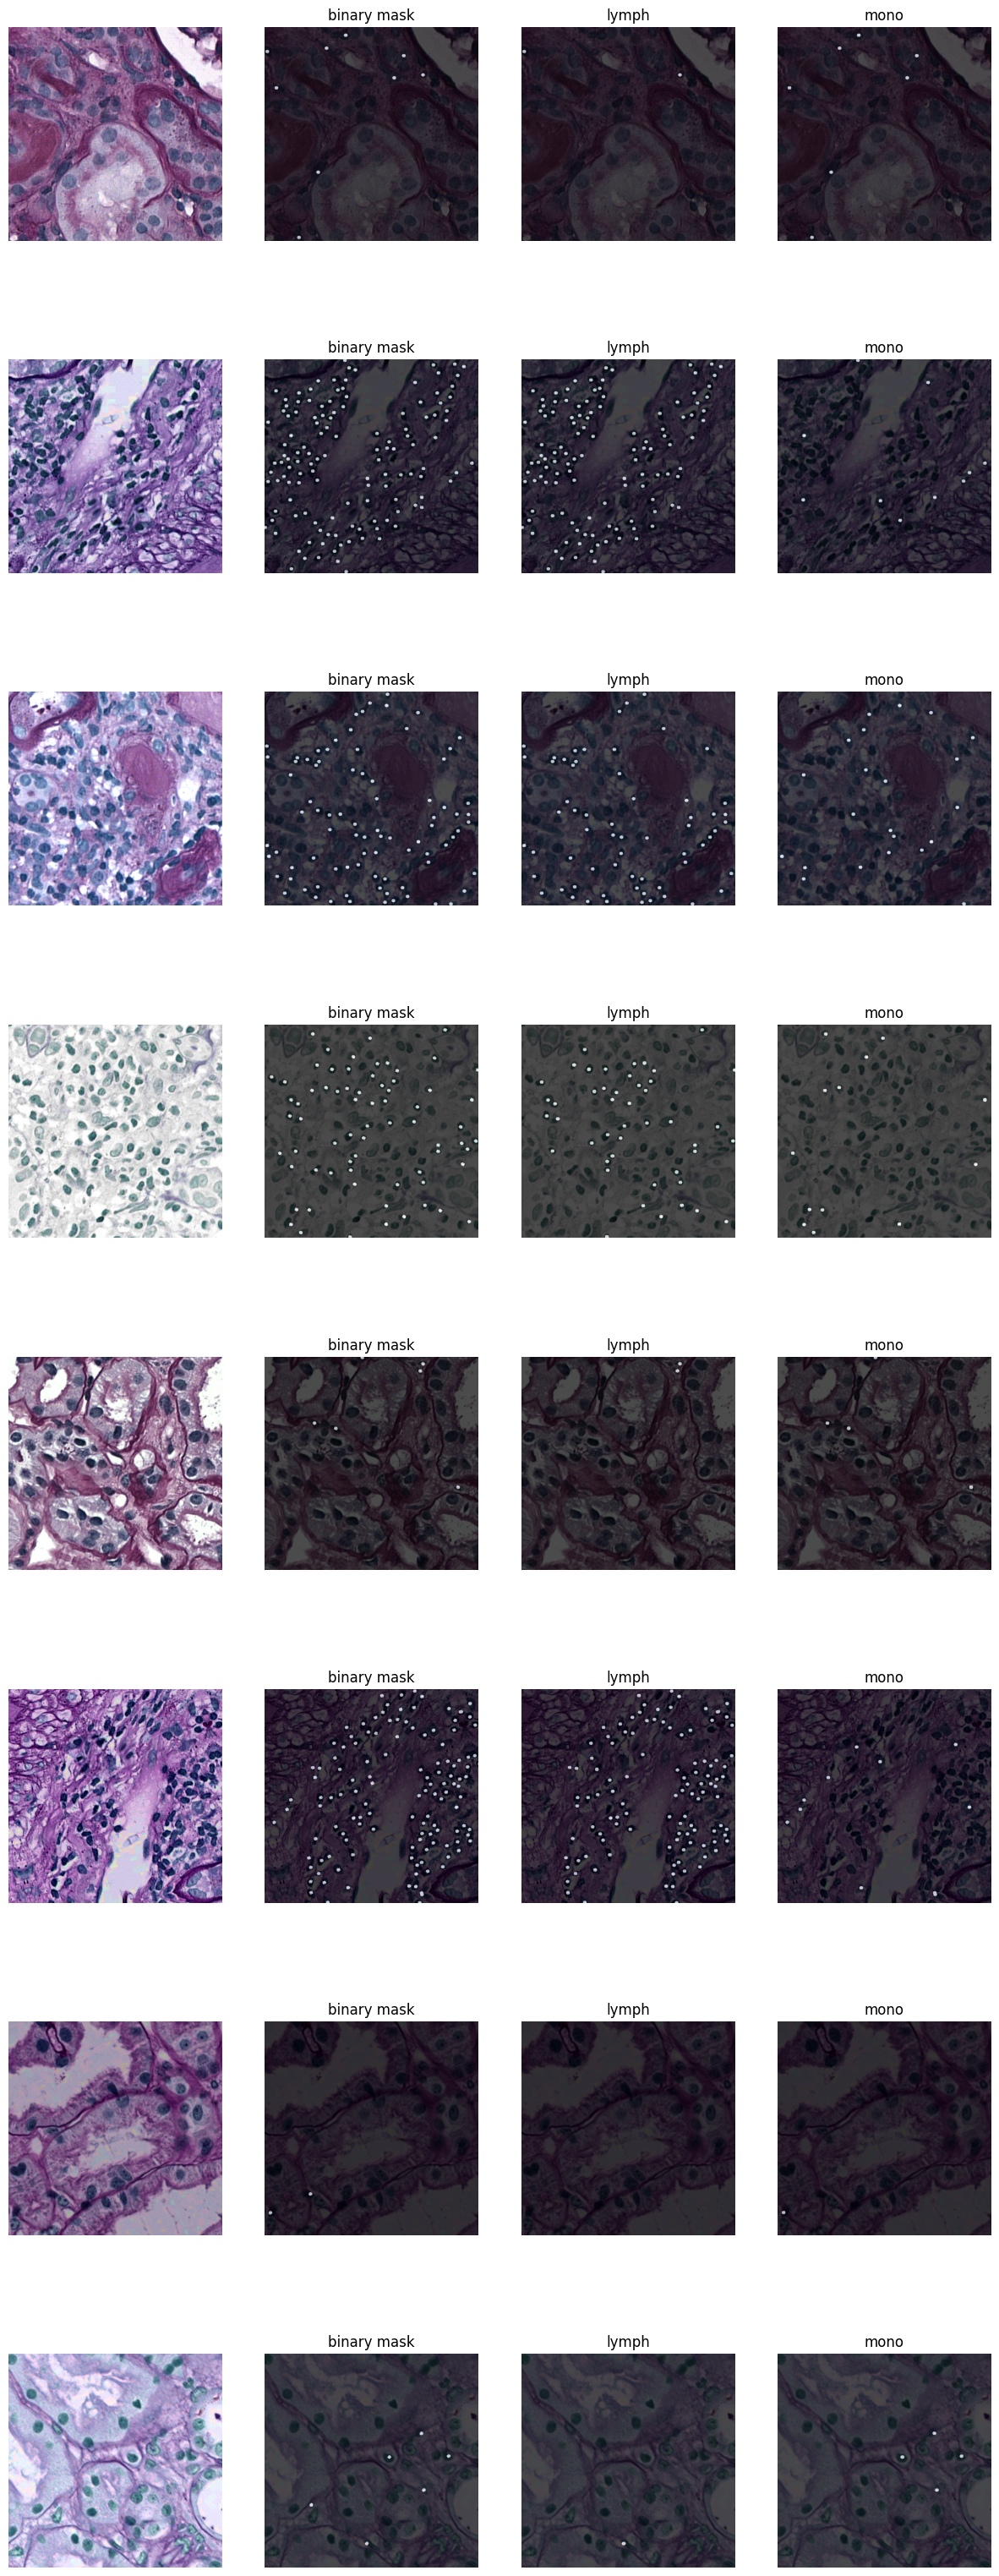

In [28]:
data = next(iter(train_loader))

print(data["id"])
fig, axes = plt.subplots(batch_size, 4, figsize=(15, 40))

for i in range(batch_size):
    image = data["image"][i].numpy()
    image = np.moveaxis(image, 0, 2)
    image = imagenet_denormalise(image)
    axes[i][0].imshow(image)

    mask = data["binary_mask"][i].numpy()
    axes[i][1].imshow(mask[0], cmap="gray")
    axes[i][1].imshow(image, alpha=0.3)
    axes[i][1].set_title("binary mask")

    class_mask = data["class_mask"][i].numpy()
    axes[i][2].imshow(class_mask[0], cmap="gray")
    axes[i][2].imshow(image, alpha=0.3)
    axes[i][2].set_title("lymph")

    axes[i][3].imshow(class_mask[1], cmap="gray")
    axes[i][3].imshow(image, alpha=0.3)
    axes[i][3].set_title("mono")

    # contour_mask = data["contour_mask"][i].numpy()
    # axes[i][4].imshow(contour_mask[0], cmap="gray")
    # axes[i][4].set_title("contour")

    for ax in axes.ravel():
        ax.axis("off")

plt.show()